In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
excel = pd.read_excel('/content/drive/MyDrive/2025SP_HW/PL/ResearchOutputs.xlsx')
step1 = pd.read_excel('/content/drive/MyDrive/2025SP_HW/PL/ResearchOutputs_Group3.xlsx')

In [5]:
excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProjectID         1735 non-null   int64  
 1   ProjectStatus     1735 non-null   object 
 2   ProjectTitle      1735 non-null   object 
 3   ProjectRDC        1735 non-null   object 
 4   ProjectStartYear  1735 non-null   int64  
 5   ProjectEndYear    1355 non-null   float64
 6   ProjectPI         1735 non-null   object 
 7   OutputTitle       1734 non-null   object 
 8   OutputBiblio      1735 non-null   object 
 9   OutputType        1735 non-null   object 
 10  OutputStatus      1734 non-null   object 
 11  OutputVenue       1488 non-null   object 
 12  OutputYear        1731 non-null   float64
 13  OutputMonth       353 non-null    object 
 14  OutputVolume      462 non-null    object 
 15  OutputNumber      842 non-null    object 
 16  OutputPages       387 non-null    object 


In [6]:
step1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2393 entries, 0 to 2392
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DOI           2393 non-null   object 
 1   OutputTitle   2393 non-null   object 
 2   OutputBiblio  2393 non-null   object 
 3   OutputType    2356 non-null   object 
 4   OutputStatus  2393 non-null   object 
 5   OutputVenue   2393 non-null   object 
 6   OutputYear    2393 non-null   float64
 7   OutputMonth   2085 non-null   float64
 8   OutputVolume  2060 non-null   object 
 9   OutputNumber  1835 non-null   object 
 10  OutputPages   1319 non-null   object 
 11  author        2393 non-null   object 
 12  Proj ID       2393 non-null   object 
 13  Status        2393 non-null   object 
 14  RDC           2393 non-null   object 
 15  Start Year    2393 non-null   object 
 16  End Year      1723 non-null   object 
 17  PI            2393 non-null   object 
dtypes: float64(2), object(16)
me

In [7]:
step1['Proj ID'] = step1['Proj ID'].str.split(',')

#Strip whitespace from each project ID
step1 = step1.explode('Proj ID')
step1['Proj ID'] = step1['Proj ID'].str.strip()

#Convert back to numeric if needed
step1['Proj ID'] = pd.to_numeric(step1['Proj ID'], errors='coerce')

merged = pd.merge(excel,step1,how='left',left_on=['ProjectID', 'OutputTitle'],right_on=['Proj ID', 'OutputTitle'])

merged.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1784 entries, 0 to 1783
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ProjectID         1784 non-null   int64  
 1   ProjectStatus     1784 non-null   object 
 2   ProjectTitle      1784 non-null   object 
 3   ProjectRDC        1784 non-null   object 
 4   ProjectStartYear  1784 non-null   int64  
 5   ProjectEndYear    1390 non-null   float64
 6   ProjectPI         1784 non-null   object 
 7   OutputTitle       1783 non-null   object 
 8   OutputBiblio_x    1784 non-null   object 
 9   OutputType_x      1784 non-null   object 
 10  OutputStatus_x    1783 non-null   object 
 11  OutputVenue_x     1532 non-null   object 
 12  OutputYear_x      1780 non-null   float64
 13  OutputMonth_x     364 non-null    object 
 14  OutputVolume_x    478 non-null    object 
 15  OutputNumber_x    871 non-null    object 
 16  OutputPages_x     400 non-null    object 


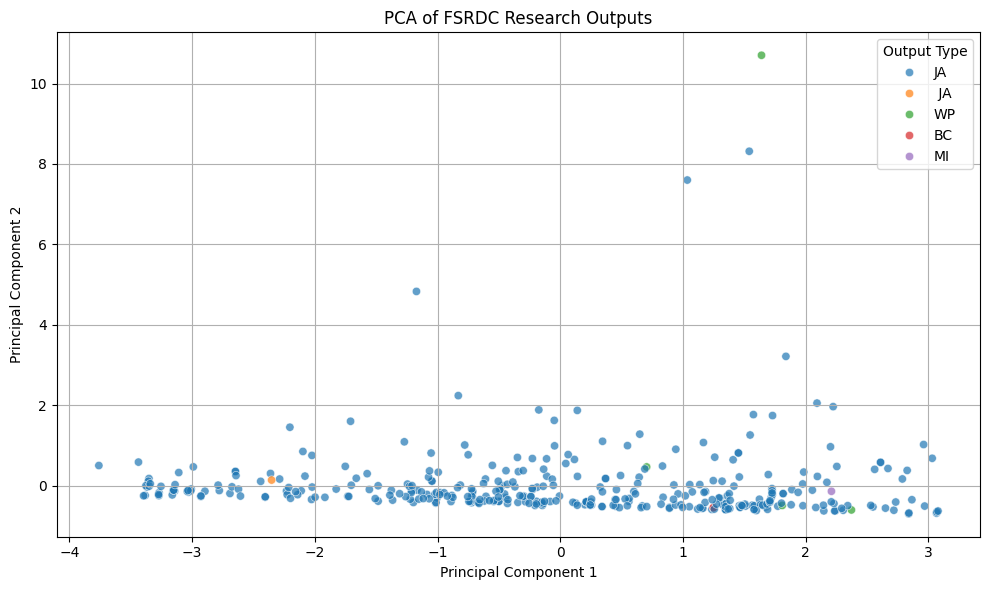

In [8]:
columns_for_pca = [
    'ProjectStartYear', 'ProjectEndYear', 'OutputYear_x', 'OutputPages_x',
    'OutputType_x', 'OutputStatus_x', 'ProjectRDC'
]

# Drop rows with missing values
df_pca = merged[columns_for_pca].dropna()

# Extract first number from OutputPages (e.g., "84-96" → 84)
df_pca['OutputPages_x'] = df_pca['OutputPages_x'].astype(str).str.extract(r'(\d+)').astype(float)

# Define feature types
numerical_features = ['ProjectStartYear', 'ProjectEndYear', 'OutputYear_x', 'OutputPages_x']
categorical_features = ['OutputType_x', 'OutputStatus_x', 'ProjectRDC']

# Preprocessing and PCA pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))
])

# Fit and transform PCA
pca_result = pipeline.fit_transform(df_pca)

# Build a DataFrame for visualization
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['OutputType_x'] = df_pca['OutputType_x'].values

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='OutputType_x', alpha=0.7)
plt.title("PCA of FSRDC Research Outputs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Output Type")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
df = merged.copy()

df['OutputPages_x'] = df['OutputPages_x'].astype(str).str.extract(r'(\d+)').astype(float)

# Drop rows with missing values in required columns
cols = [
    'ProjectStartYear', 'ProjectEndYear',
    'OutputYear_x', 'OutputPages_x',
    'OutputStatus_x', 'ProjectRDC', 'OutputType_x'
]
df = df[cols].dropna()

# Define features and target
X = df.drop(columns='OutputType_x')
y = df['OutputType_x']

# Identify feature types
numerical = ['ProjectStartYear', 'ProjectEndYear', 'OutputYear_x', 'OutputPages_x']
categorical = ['OutputStatus_x', 'ProjectRDC']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
])

# Full modeling pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          JA       0.99      1.00      0.99        75
          WP       0.00      0.00      0.00         1

    accuracy                           0.99        76
   macro avg       0.49      0.50      0.50        76
weighted avg       0.97      0.99      0.98        76

Confusion Matrix:
 [[75  0]
 [ 1  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# Shared Setups for different Clustering examples

# Select relevant features for clustering
features = [
    'ProjectStartYear', 'ProjectEndYear', 'OutputYear_x', 'OutputPages_x',
    'ProjectRDC', 'OutputStatus_x', 'OutputType_x'
]

# Clean and prepare
df_cluster = merged[features].dropna()
df_cluster['OutputPages_x'] = df_cluster['OutputPages_x'].astype(str).str.extract(r'(\d+)').astype(float)

# Identify feature types
numerical = ['ProjectStartYear', 'ProjectEndYear', 'OutputYear_x', 'OutputPages_x']
categorical = ['ProjectRDC', 'OutputStatus_x', 'OutputType_x']

# Use default sparse=True to avoid version issues
encoder = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', encoder, categorical)
])

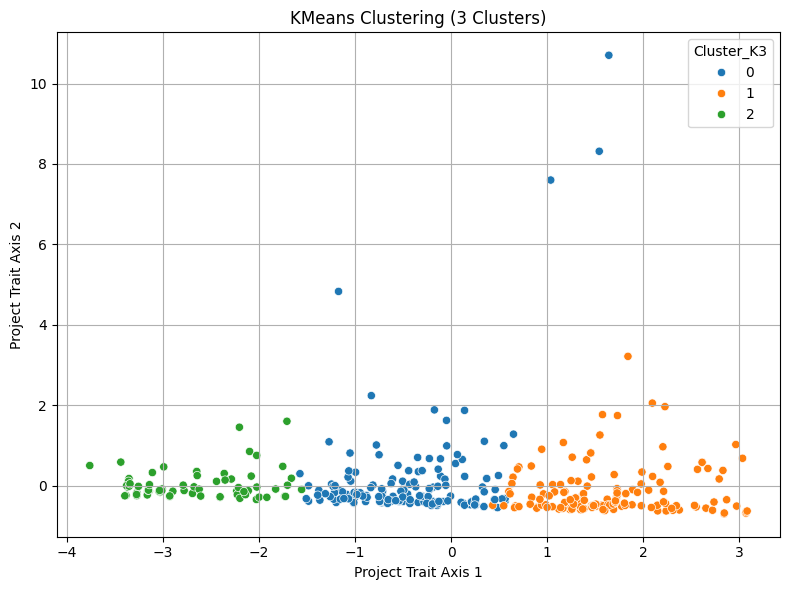

In [16]:
# KMeans Clustering (3 clusters)

pipeline_k3 = Pipeline([
    ('preprocessing', preprocessor),
    ('cluster', KMeans(n_clusters=3, random_state=42))
])

df_cluster['Cluster_K3'] = pipeline_k3.fit_predict(df_cluster)

# PCA for visualization
X_2D_k3 = PCA(n_components=2).fit_transform(
    pipeline_k3.named_steps['preprocessing'].transform(df_cluster).toarray()
    if hasattr(pipeline_k3.named_steps['preprocessing'].transform(df_cluster), 'toarray')
    else pipeline_k3.named_steps['preprocessing'].transform(df_cluster)
)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2D_k3[:, 0], y=X_2D_k3[:, 1], hue=df_cluster['Cluster_K3'], palette='tab10')
plt.title("KMeans Clustering (3 Clusters)")
plt.xlabel("Project Trait Axis 1")
plt.ylabel("Project Trait Axis 2")
plt.grid(True)
plt.tight_layout()
plt.show()


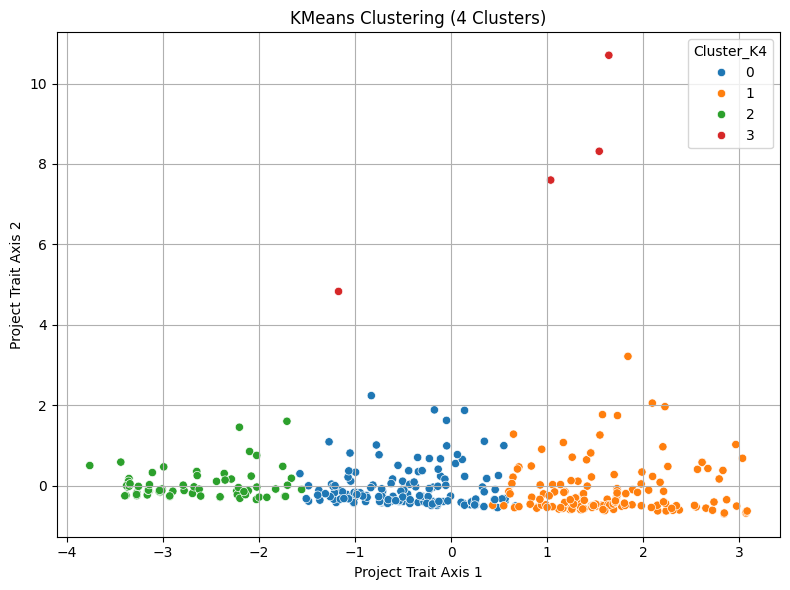

In [17]:
# KMeans Clustering (4 clusters)

pipeline_k4 = Pipeline([
    ('preprocessing', preprocessor),
    ('cluster', KMeans(n_clusters=4, random_state=42))
])

df_cluster['Cluster_K4'] = pipeline_k4.fit_predict(df_cluster)

X_2D_k4 = PCA(n_components=2).fit_transform(
    pipeline_k4.named_steps['preprocessing'].transform(df_cluster).toarray()
    if hasattr(pipeline_k4.named_steps['preprocessing'].transform(df_cluster), 'toarray')
    else pipeline_k4.named_steps['preprocessing'].transform(df_cluster)
)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2D_k4[:, 0], y=X_2D_k4[:, 1], hue=df_cluster['Cluster_K4'], palette='tab10')
plt.title("KMeans Clustering (4 Clusters)")
plt.xlabel("Project Trait Axis 1")
plt.ylabel("Project Trait Axis 2")
plt.grid(True)
plt.tight_layout()
plt.show()


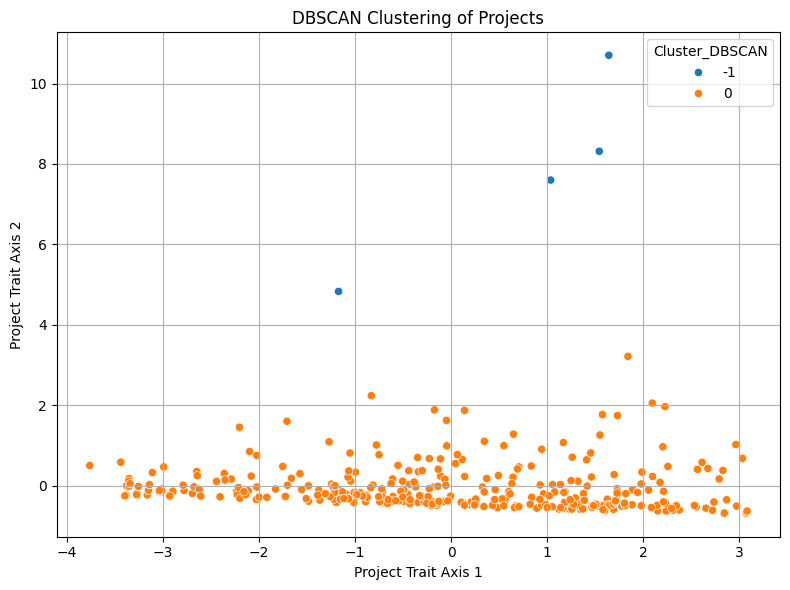

In [21]:
# DBSCAN Clustering

# Manual transformation for DBSCAN
X_transformed = preprocessor.fit_transform(df_cluster)
X_dense = X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed

db = DBSCAN(eps=2.5, min_samples=3)
df_cluster['Cluster_DBSCAN'] = db.fit_predict(X_dense)

X_2D_db = PCA(n_components=2).fit_transform(X_dense)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2D_db[:, 0], y=X_2D_db[:, 1], hue=df_cluster['Cluster_DBSCAN'], palette='tab10')
plt.title("DBSCAN Clustering of Projects")
plt.xlabel("Project Trait Axis 1")
plt.ylabel("Project Trait Axis 2")
plt.grid(True)
plt.tight_layout()
plt.show()


 LDA Topics:
Topic 1: effects | insurance | level | health | census | firms | data | evidence
Topic 2: market | essays | business | innovation | productivity | labor | firm | firms
Topic 3: plant | effects | business | manufacturing | evidence | productivity | international | trade
Topic 4: market | states | united | earnings | new | evidence | income | labor
Topic 5: employment | industry | energy | market | dynamics | evidence | performance | firm


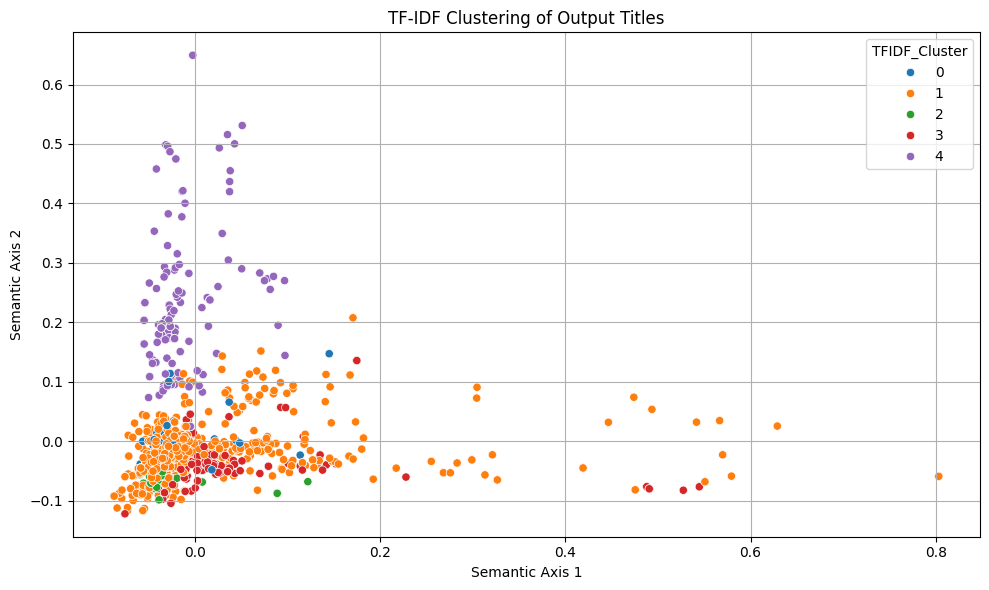

In [23]:
# Text Processing on merged['OutputTitle']

# Drop missing or invalid titles
df_text = merged[['OutputTitle']].dropna()
df_text['OutputTitle'] = df_text['OutputTitle'].astype(str)

# Text Clustering with TF-IDF + KMeans
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85, min_df=2, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df_text['OutputTitle'])

# Cluster using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df_text['TFIDF_Cluster'] = kmeans.fit_predict(X_tfidf)

# Reduce to 2D for plotting
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())
df_text['PC1'] = X_pca[:, 0]
df_text['PC2'] = X_pca[:, 1]


# Topic Modeling with LDA

count_vectorizer = CountVectorizer(stop_words='english', max_df=0.85, min_df=3)
X_counts = count_vectorizer.fit_transform(df_text['OutputTitle'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_counts)

# Print top words per topic
print("\n LDA Topics:")
words = count_vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[-8:]]
    print(f"Topic {i+1}: {' | '.join(top_words)}")



# Visualize Clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_text, x='PC1', y='PC2', hue='TFIDF_Cluster', palette='tab10')
plt.title("TF-IDF Clustering of Output Titles")
plt.xlabel("Semantic Axis 1")
plt.ylabel("Semantic Axis 2")
plt.grid(True)
plt.tight_layout()
plt.show()